In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys
from IPython.display import display

In [3]:
def on_kaggle() -> bool:
    try:
        import gresearch_crypto
        return True
    except ModuleNotFoundError:
        return False

In [4]:
# HYPER PARAMETERS
ON_KAGGLE = on_kaggle()
SAMPLE_LEVEL = 0
FORCE_REWRITE = True

In [5]:
if not ON_KAGGLE and os.path.abspath('.').endswith('notebook'):
    os.chdir('../')

In [6]:
#IMPORT_SCRIPT!
if not ON_KAGGLE and '.' not in sys.path:
    sys.path.append('.')
from src.metrics import *
from src.data import merge_asset_details
from src.cv import TimeSeriesSplit, get_date_range
from src.modeling import Evaluator
from src.metrics import compute_metrics, compute_correlation
from src.pipeline.feature_gen import compute_instant_features
from src.data import infer_dtypes
from src.pipeline import EXPECTED_RAW_COLS
from src.pipeline.transforms import FilterFeatures
from src.modeling import Evaluator

In [7]:
def setup_dir(on_kaggle: bool = True, sample_level: int = 0):
    if on_kaggle:
        data_dir = Path('../input/g-research-crypto-forecasting/')
        raw_train_dir = (Path('../input/create-sample-dataset/data/raw/')
                         if sample_level > 0 else data_dir) 
    else:
        data_dir = raw_train_dir = Path('data/raw')
    
    if sample_level > 0:
        raw_train_dir = raw_train_dir.joinpath('sample', str(sample_level))
    
    return data_dir, raw_train_dir

In [8]:
DATA_DIR, RAW_TRAIN_DIR = setup_dir(ON_KAGGLE, sample_level=SAMPLE_LEVEL)
RAW_TRAIN_PATH = RAW_TRAIN_DIR / 'train.csv'
ASSET_DETAILS_PATH = DATA_DIR / 'asset_details.csv'

In [9]:
RAW_TRAIN_DIR

PosixPath('data/raw')

In [10]:
DATA_DIR

PosixPath('data/raw')

In [11]:
%%time 
raw_data = pd.read_csv(RAW_TRAIN_PATH)

CPU times: user 21.6 s, sys: 2.57 s, total: 24.2 s
Wall time: 29 s


## create train set

In [12]:
PREPRO_PARAMS = {'window': 60}
MAIN_INDEX = ['timestamp', 'Asset_ID']

In [13]:
# get valid data only, drop where the target is NaN 
data = raw_data.dropna(subset=['Target'])
# format time to human readable 
data['time'] = pd.to_datetime(data['timestamp'], unit='s')
# merge asset names
data = merge_asset_details(data, ASSET_DETAILS_PATH)

/home/med/anaconda3/envs/crypto-g/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [14]:
data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,Asset_Name
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218,2018-01-01 00:01:00,Bitcoin Cash
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399,2018-01-01 00:01:00,Binance Coin
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643,2018-01-01 00:01:00,Bitcoin
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922,2018-01-01 00:01:00,EOS.IO
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264,2018-01-01 00:01:00,Ethereum Classic


In [15]:
data.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,Asset_Name
23486463,1632181440,9,163.0,156.502000,156.620000,156.000000,156.075667,7.381963e+02,156.260253,-0.001154,2021-09-20 23:44:00,Litecoin
23486464,1632181440,10,23.0,2420.146667,2421.000000,2412.779000,2414.069667,1.315794e+00,2417.326038,0.009831,2021-09-20 23:44:00,Maker
23486465,1632181440,13,512.0,0.090989,0.091133,0.090831,0.090885,1.900695e+06,0.090943,0.004163,2021-09-20 23:44:00,TRON
23486466,1632181440,12,193.0,0.280952,0.281300,0.280175,0.280403,1.628699e+05,0.280655,0.000449,2021-09-20 23:44:00,Stellar
23486467,1632181440,11,38.0,232.075000,232.300000,231.310000,231.680000,4.914804e+01,231.794078,0.002568,2021-09-20 23:44:00,Monero


In [16]:
data = infer_dtypes(data)

In [17]:
data = compute_instant_features(data)

In [18]:
data.head()

,timestamp,Asset_ID,Count,High,Low,Close,Volume,VWAP,Target,time,Asset_Name,high_low_return,open_close_return,upper_shadow,lower_shadow,dolar_amount,vol_per_trades
0,1514764860,2,40.0,1.009644,0.991820,2374.590088,19.233005,2373.116455,-0.004218,2018-01-01 00:01:00,Bitcoin Cash,0.702093,0.692728,0.000425,2394.174316,45670.503485,0.480825
1,1514764860,0,5.0,1.000000,1.000000,8.530000,78.380000,8.530000,-0.014399,2018-01-01 00:01:00,Binance Coin,0.693147,0.693147,0.117233,8.530000,668.581379,15.676000
2,1514764860,1,229.0,1.012910,0.987779,13850.175781,31.550062,13827.062500,-0.014643,2018-01-01 00:01:00,Bitcoin,0.705788,0.693689,0.000073,14006.370117,436973.897961,0.137773
3,1514764860,5,32.0,1.000000,0.999621,7.657600,6626.713370,7.657713,-0.013922,2018-01-01 00:01:00,EOS.IO,0.693337,0.693017,0.130555,7.660500,50744.719811,207.084793
4,1514764860,7,5.0,1.000000,0.998225,25.877001,121.087310,25.891363,-0.008264,2018-01-01 00:01:00,Ethereum Classic,0.694036,0.692317,0.038580,25.923006,3133.376419,24.217462


In [19]:
data.isna().mean()

timestamp            0.000000e+00
Asset_ID             0.000000e+00
Count                0.000000e+00
High                 0.000000e+00
Low                  0.000000e+00
Close                0.000000e+00
Volume               0.000000e+00
VWAP                 3.831994e-07
Target               0.000000e+00
time                 0.000000e+00
Asset_Name           0.000000e+00
high_low_return      0.000000e+00
open_close_return    0.000000e+00
upper_shadow         0.000000e+00
lower_shadow         0.000000e+00
dolar_amount         0.000000e+00
vol_per_trades       0.000000e+00
dtype: float64

In [20]:
data.fillna({'VWAP': data['VWAP'].mean()}, inplace=True)

In [21]:
data.isna().mean()

timestamp            0.0
Asset_ID             0.0
Count                0.0
High                 0.0
Low                  0.0
Close                0.0
Volume               0.0
VWAP                 0.0
Target               0.0
time                 0.0
Asset_Name           0.0
high_low_return      0.0
open_close_return    0.0
upper_shadow         0.0
lower_shadow         0.0
dolar_amount         0.0
vol_per_trades       0.0
dtype: float64

In [22]:
list(data.columns)

['timestamp',
 'Asset_ID',
 'Count',
 'High',
 'Low',
 'Close',
 'Volume',
 'VWAP',
 'Target',
 'time',
 'Asset_Name',
 'high_low_return',
 'open_close_return',
 'upper_shadow',
 'lower_shadow',
 'dolar_amount',
 'vol_per_trades']

In [23]:
FEATURES = [
'Count',
'High',
'Low',
'Close',
'Volume',
'VWAP',
'high_low_return',
'open_close_return',
'upper_shadow',
'lower_shadow',
'dolar_amount',
'vol_per_trades'
]

In [24]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

class ProfitLogisticRegression(LogisticRegression):
    def fit(self, X, y, *args, **kwargs):
        profit = (y >= 0)
        self.mean = profit.mean()
        return super().fit(X, profit, *args, **kwargs)

    def predict(self, X):
        yhat = super().predict_proba(X)[:, 1]
        return (yhat - self.mean)
    

def build_model(params={'C': 1.}):
    model = Pipeline([('filter', FilterFeatures(FEATURES)),
                      ('norm', MinMaxScaler()),
                      ('model', ProfitLogisticRegression(C=params['C'], random_state=1))])
    return model

In [25]:
def train_model(config, train_data, valid_data, pipeline=None):
    model  = build_model(config['model'])

    if config['training']['time_decay_alpha'] is not None:
        time_decay_alpha = config['training']['time_decay_alpha']
        print(f'using exponential_time_decay with alpha {time_decay_alpha}')
        timesteps = ((train_data['timestamp'].max() - train_data['timestamp'])//60//60//24)
        weight = time_decay_alpha ** timesteps
    else:
        weight = None

    model.fit(train_data, train_data['Target'], model__sample_weight=weight)
    return model


def get_mask_for_asset(data: pd.DataFrame, asset_id: int):
    return (data['Asset_ID'] == asset_id)


def get_data_for_asset(data: pd.DataFrame, asset_id: int):
    mask = get_mask_for_asset(data, asset_id)
    return data.loc[mask, :].reset_index(drop=True)

In [26]:
PRIVATE_LB_RANGE = [['2020-01-01', '2020-04-01']]
PULIC_LB_RANGE = ['2021-06-13',
                  '2021-09-13'] # 3 MONTH WORTH OF DATA


if SAMPLE_LEVEL==2:
    EVAL_PERIODS = [['2021-09-11', '2021-09-13']]
elif SAMPLE_LEVEL == 1:
    EVAL_PERIODS = [PULIC_LB_RANGE]
else:
    EVAL_PERIODS =  [
                     ['2020-01-01', '2020-04-01'],
                     ['2020-09-01', '2021-01-01'],
                     ['2021-01-01', '2021-04-01'],
                     ['2021-04-01', '2021-07-01']
                     ]

In [27]:
EVAL_PERIODS

[['2020-01-01', '2020-04-01'],
 ['2020-09-01', '2021-01-01'],
 ['2021-01-01', '2021-04-01'],
 ['2021-04-01', '2021-07-01']]

In [28]:
CV_PARAMS = {'gap_unit': 'min', 'dt_col': 'time'}

CV = TimeSeriesSplit(EVAL_PERIODS, **CV_PARAMS)

In [29]:
def _create_fi_pd(features, importances):
    return (pd.DataFrame({'feature': features, 'importance': importances})
            .sort_values(by=['importance']).reset_index(drop=True))

def compute_fi(config, model, valid_data):
    return _create_fi_pd(model['filter'].features, model['model'].coef_[0])

In [30]:
evaluator = Evaluator(cv=CV, fi_fn=compute_fi)

In [31]:
MODEL_CONFIG = {'C': .01}
TRAIN_CONFIG = {'time_decay_alpha': 0.99}
CONFIG = {'model': MODEL_CONFIG, 'training': TRAIN_CONFIG}

In [32]:
asset_ids = data['Asset_ID'].unique()
RESULTS = {}
for asset_id in asset_ids:
    asset_data = get_data_for_asset(data, asset_id)
    asset_result = evaluator.run(train_model, CONFIG, asset_data)
    RESULTS[asset_id] = asset_result 

fold=0
using exponential_time_decay with alpha 0.99
elapsed time: 0.0338
fold=1
using exponential_time_decay with alpha 0.99
elapsed time: 0.0424
fold=2
using exponential_time_decay with alpha 0.99
elapsed time: 0.0472
fold=3
using exponential_time_decay with alpha 0.99
elapsed time: 0.0556
fold=0
using exponential_time_decay with alpha 0.99
elapsed time: 0.0364
fold=1
using exponential_time_decay with alpha 0.99
elapsed time: 0.0501
fold=2
using exponential_time_decay with alpha 0.99
elapsed time: 0.0688
fold=3
using exponential_time_decay with alpha 0.99
elapsed time: 0.0358
fold=0
using exponential_time_decay with alpha 0.99
elapsed time: 0.0422
fold=1
using exponential_time_decay with alpha 0.99
elapsed time: 0.0575
fold=2
using exponential_time_decay with alpha 0.99
elapsed time: 0.0305
fold=3
using exponential_time_decay with alpha 0.99
elapsed time: 0.0666
fold=0
using exponential_time_decay with alpha 0.99
elapsed time: 0.0330
fold=1
using exponential_time_decay with alpha 0.99

In [33]:
import itertools
inference_df = pd.concat(itertools.chain(*[asset_result['prediction'] for _, asset_result in RESULTS.items()]))

In [34]:
scores = inference_df.groupby('fold').apply(compute_metrics)
scores['eval_period'] = EVAL_PERIODS

In [35]:
scores

,corr,crypto_consistency,sharpe,corr_period_mean,corr_period_std,consistency,min_period_corr,corr_min,corr_max,corr_std,eval_period
fold,,,,,,,,,,,
0,0.013581,12.0,1.526666,0.015252,0.009990,0.923077,0.000831,-0.168709,0.063505,0.053334,"[2020-01-01, 2020-04-01]"
1,0.003373,12.0,0.538890,0.004998,0.009275,0.666667,-0.009656,-0.027277,0.058564,0.020271,"[2020-09-01, 2021-01-01]"
2,0.000546,9.0,0.318280,0.005377,0.016893,0.615385,-0.025599,-0.011453,0.035122,0.011760,"[2021-01-01, 2021-04-01]"
3,0.000547,12.0,0.008824,0.000144,0.016348,0.692308,-0.025552,-0.025384,0.072281,0.022461,"[2021-04-01, 2021-07-01]"


In [36]:
fi = pd.concat(itertools.chain(*[asset_result['fi'] for _, asset_result in RESULTS.items()]))

In [37]:
fi_stats = (fi.groupby('feature')['importance'].describe()
            .sort_values('mean', ascending=False))

In [38]:
fi_stats

,count,mean,std,min,25%,50%,75%,max
feature,,,,,,,,
upper_shadow,56.0,0.090336,0.107069,-0.180432,0.007964,0.092534,0.170586,0.290467
Volume,56.0,0.039813,0.070138,-0.073765,-0.007242,0.029603,0.075684,0.258006
Count,56.0,0.036059,0.094763,-0.120414,-0.032594,0.017878,0.112671,0.299535
dolar_amount,56.0,0.029576,0.061814,-0.069792,-0.017405,0.013060,0.070455,0.257623
vol_per_trades,56.0,0.006933,0.033539,-0.095072,-0.004046,0.005992,0.018791,0.114594
high_low_return,56.0,-0.002399,0.031627,-0.096879,-0.009205,-0.000977,0.008667,0.112257
High,56.0,-0.016894,0.023486,-0.088500,-0.030759,-0.011257,-0.006259,0.055992
Low,56.0,-0.017350,0.047055,-0.150617,-0.034154,-0.015854,0.000312,0.139795
lower_shadow,56.0,-0.037830,0.047897,-0.172905,-0.057261,-0.024063,-0.005241,0.049354


<AxesSubplot:xlabel='importance', ylabel='feature'>

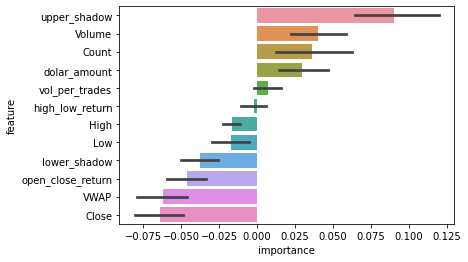

In [39]:
sns.barplot(data=fi, y='feature', x='importance', order=fi_stats.index)

In [40]:
# def add_kaggle_index_columns(data: pd.DataFrame):
#     data['row_id'] = list(range(len(data)))
#     data['row_id'] = data['row_id'].astype(np.int32)
#     group_num = data[['timestamp']].drop_duplicates().sort_values(by='timestamp')
#     group_num['group_num'] = list(range(len(group_num)))
#     data = data.merge(group_num, on='timestamp', how='left')
#     assert data['group_num'].isna().sum() == 0
#     return data
    
    
# EXPECTED_RAW_COLS = ['timestamp', 'Asset_ID', 'Count',
#                      'Open', 'High', 'Low', 'Close',
#                      'Volume', 'VWAP']

# def simulate_kaggle_api(data: pd.DataFrame):
#     copy_data = data.copy()
#     data = add_kaggle_index_columns(copy_data)
    
#     for group_id, group_data in data.groupby('group_num'):
#         group_data = group_data.reset_index(drop=True)
#         submission = group_data.loc[:, ['row_id', 'Target']]
#         yield group_data.loc[:, EXPECTED_RAW_COLS + ['row_id']], submission


In [41]:
# raw_test_mask = raw_data['timestamp'].between(valid_data['timestamp'].min(), valid_data['timestamp'].max())
# raw_test_df_iter = raw_data[raw_test_mask].reset_index(drop=True)
# assert np.allclose(raw_test_df_iter['Target'].dropna(), valid_data['Target'])

In [42]:
# raw_test_df_iter['timestamp'].min()

In [43]:
# test_iter = simulate_kaggle_api(raw_test_df_iter)

In [44]:
# from src.preprocessing import inference
# import time
# import sys

In [45]:
# actual_submission = []
# elapsed_times = []
# i = 0
# for raw_test_df, submission in test_iter:
#     print('{} days'.format(i/(24 * 60)), end='\r')
#     start_inference_time = time.time()
#     submission = inference(test_data=raw_test_df, submission=submission,
#                             models=MODELS)
#     inference_elapsed_time = time.time() - start_inference_time 
#     elapsed_times.append(inference_elapsed_time)
#     actual_submission.append(submission)
#     i+=1
#     sys.stdout.flush()

In [46]:
# actual_submission_df = pd.concat(actual_submission, ignore_index=True)

In [47]:
# index_template = raw_test_df_iter[['timestamp', 'Asset_ID']].assign(row_id=np.arange(len(raw_test_df_iter)))

In [48]:
# actual_submission_df = index_template.merge(actual_submission_df, on=['row_id'], how='left')

In [49]:
# yhat_test = valid_data[['timestamp', 'Asset_ID', 'yhat']].merge(actual_submission_df, on=['timestamp', 'Asset_ID'], how='left')
# yhat_test = yhat_test.dropna()

In [50]:
# error = (yhat_test['yhat'] -  yhat_test['Target']) / yhat_test['yhat']
# error.abs().max()

In [51]:
# np.allclose(yhat_test['yhat'], yhat_test['Target'])

In [52]:
# np.mean(elapsed_times), np.max(elapsed_times)

In [53]:
# np.sum(elapsed_times) / 60

In [54]:
# days = 90
# total = 0.06107479883276898 * (days * 24 * 60)
# total / 60 / 60